In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import csv
import math
import scipy

import dataset
import datasplit
import model.models as models
import trainer
import utils

# TEST on MONO DISCRETE

In [2]:
# LOAD
# folders
models_folder = 'G:/PracaMagisterska/Kod_na_magisterke/gfx-classifier_RNN_version-models_and_results/models'
model_name = '20210409_setnetcond_mono_disc_best'
results_folder = 'G:/PracaMagisterska/Kod_na_magisterke/gfx-classifier_RNN_version-models_and_results/result'
results_subfolder = '20210409_setnetcond_mono_disc'

# load model
setnetcond = torch.load('%s/%s' % (models_folder, model_name), map_location=torch.device('cpu'))

# load results
all_train_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_losses.npy')), allow_pickle=True)
all_train_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_correct.npy')), allow_pickle=True)
best_train_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_train_results.npy')), allow_pickle=True)

all_val_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_losses.npy')), allow_pickle=True)
all_val_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_correct.npy')), allow_pickle=True)
best_val_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_val_results.npy')), allow_pickle=True)

all_test_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_losses.npy')), allow_pickle=True)
all_test_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_correct.npy')), allow_pickle=True)
best_test_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_test_results.npy')), allow_pickle=True)

fx_labels = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'fx_labels.npy')), allow_pickle=True)

# datasets sizes
train_set_size = best_train_results.shape[0]
val_set_size = best_val_results.shape[0]
test_set_size = best_test_results.shape[0]

# example
best_train_results[0]

C:\Users\maszy\AppData\Local\Temp\ipykernel_21112\3506253615.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  setnetcond = torch.load('%s/%s' % (models_folder, model_name

array([60827, 'P94-48140-RBM-T10S8-41445',
       array([1.   , 0.805, 0.998], dtype=float32),
       array([1. , 0.8, 1. ], dtype=float32)], dtype=object)

Best Train Accuracy:  96.81169102296451
Epoch:  43

Best Val Accuracy:  93.9275514805351
Epoch:  33

Test Accuracy:  93.88528138528139
Epoch:  39



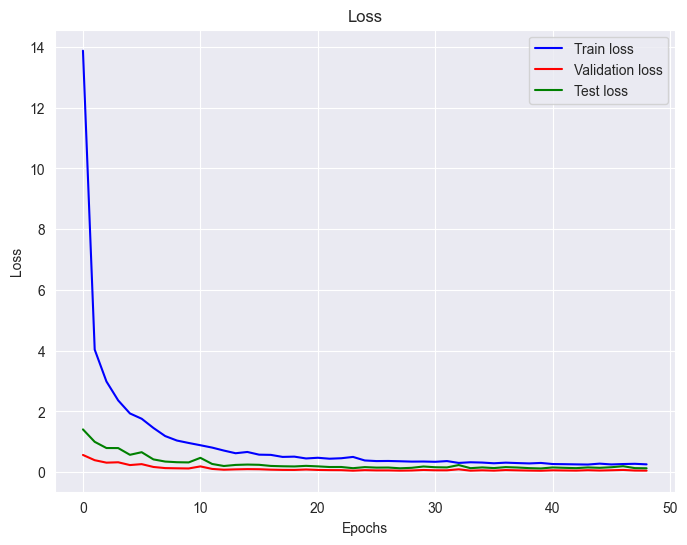

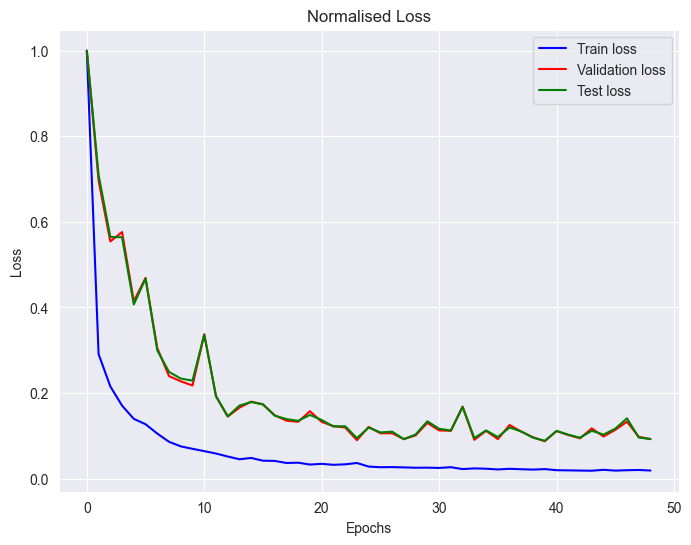

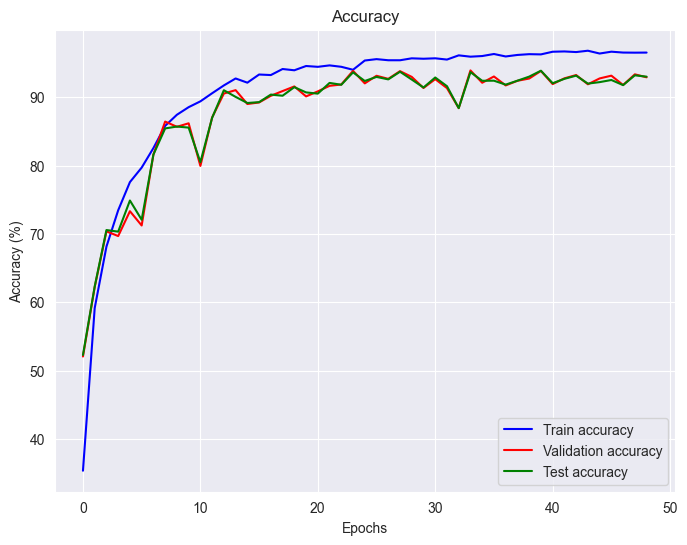

In [3]:
# Ustawienie ścieżki do zapisu
save_path = 'G:/PracaMagisterska/Kod_na_magisterke/gfx-classifier_RNN_version-models_and_results/result/figures/Setnetcond_mono_disc_plots'

# BEST RESULTS
print('Best Train Accuracy: ', 100 * max(all_train_correct) / train_set_size)
print('Epoch: ', np.argmax(all_train_correct))
print()
print('Best Val Accuracy: ', 100 * max(all_val_correct) / val_set_size)
print('Epoch: ', np.argmax(all_val_correct))
print()
print('Test Accuracy: ', 100 * max(all_test_correct) / test_set_size)
print('Epoch: ', np.argmax(all_test_correct))
print()

# LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, all_train_losses, 'b', label='Train loss')
plt.plot(epochs, all_val_losses, 'r', label='Validation loss')
plt.plot(epochs, all_test_losses, 'g', label='Test loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{save_path}/loss_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

# NORMALISED LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, np.array(all_train_losses) / max(all_train_losses), 'b', label='Train loss')
plt.plot(epochs, np.array(all_val_losses) / max(all_val_losses), 'r', label='Validation loss')
plt.plot(epochs, np.array(all_test_losses) / max(all_test_losses), 'g', label='Test loss')
plt.title('Normalised Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{save_path}/normalised_loss_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

# ACCURACY
all_train_perc_correct = 100 * np.array(all_train_correct) / train_set_size
all_val_perc_correct = 100 * np.array(all_val_correct) / val_set_size
all_test_perc_correct = 100 * np.array(all_test_correct) / test_set_size
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, all_train_perc_correct, 'b', label='Train accuracy')
plt.plot(epochs, all_val_perc_correct, 'r', label='Validation accuracy')
plt.plot(epochs, all_test_perc_correct, 'g', label='Test accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f'{save_path}/accuracy_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

In [4]:
# DATAFRAME
test_indexes_mono_disc = best_test_results[:, 0]
test_filenames_mono_disc = best_test_results[:, 1] 
test_preds_mono_disc = np.stack(best_test_results[:, 2])
test_targets_mono_disc = np.stack(best_test_results[:, 3])
test_abs_err_mono_disc = np.stack(abs(test_preds_mono_disc - test_targets_mono_disc))
test_err_mono_disc = np.stack(test_preds_mono_disc - test_targets_mono_disc)

test_df_mono_disc = pd.DataFrame(data={
    'index': test_indexes_mono_disc, 
    'filename': test_filenames_mono_disc,
    'level_pred': test_preds_mono_disc[:,0], 
    'gain_pred': test_preds_mono_disc[:,1],
    'tone_eq1_pred': test_preds_mono_disc[:,2], 
    'level_targ': test_targets_mono_disc[:,0], 
    'gain_targ': test_targets_mono_disc[:,1],
    'tone_eq1_targ': test_targets_mono_disc[:,2], 
    'level_err': test_err_mono_disc[:,0], 
    'gain_err': test_err_mono_disc[:,1],
    'tone_eq1_err': test_err_mono_disc[:,2], 
    'level_abs': test_abs_err_mono_disc[:,0], 
    'gain_abs': test_abs_err_mono_disc[:,1],
    'tone_eq1_abs': test_abs_err_mono_disc[:,2], 
})

print(len(test_df_mono_disc))
test_df_mono_disc[:3]

16632


,index,filename,level_pred,gain_pred,tone_eq1_pred,level_targ,gain_targ,tone_eq1_targ,level_err,gain_err,tone_eq1_err,level_abs,gain_abs,tone_eq1_abs
0,62773,P95-47230-RBM-T5S2-41534,1.0,0.203,0.504,1.0,0.2,0.5,0.0,0.003,0.004,0.0,0.003,0.004
1,48122,P64-47160-RAT-D10F2-41264,1.0,0.998,0.200,1.0,1.0,0.2,0.0,-0.002,0.000,0.0,0.002,0.000
2,62462,P95-45220-RBM-T0S5-41517,1.0,0.468,-0.000,1.0,0.5,0.0,0.0,-0.032,-0.000,0.0,0.032,0.000


In [5]:
# MAE
level_mae_mono_disc = sum(test_df_mono_disc.level_abs)/test_set_size
gain_mae_mono_disc = sum(test_df_mono_disc.gain_abs)/test_set_size
tone_eq1_mae_mono_disc = sum(test_df_mono_disc.tone_eq1_abs)/test_set_size

print('level_mae: ', level_mae_mono_disc)
print('gain_mae: ', gain_mae_mono_disc)
print('tone_eq1_mae: ', tone_eq1_mae_mono_disc)

# RMSE
level_rmse_mono_disc = math.sqrt(sum(test_df_mono_disc.level_abs**2)/test_set_size)
gain_rmse_mono_disc = math.sqrt(sum(test_df_mono_disc.gain_abs**2)/test_set_size)
tone_eq1_rmse_mono_disc = math.sqrt(sum(test_df_mono_disc.tone_eq1_abs**2)/test_set_size)

print('level_rmse: ', level_rmse_mono_disc)
print('gain_rmse: ', gain_rmse_mono_disc)
print('tone_eq1_rmse: ', tone_eq1_rmse_mono_disc)

level_mae:  1.8037285811629303e-07
gain_mae:  0.012165884583531742
tone_eq1_mae:  0.017637746719372564
level_rmse:  1.3430210180768743e-05
gain_rmse:  0.02799535599582004
tone_eq1_rmse:  0.03810899381852858


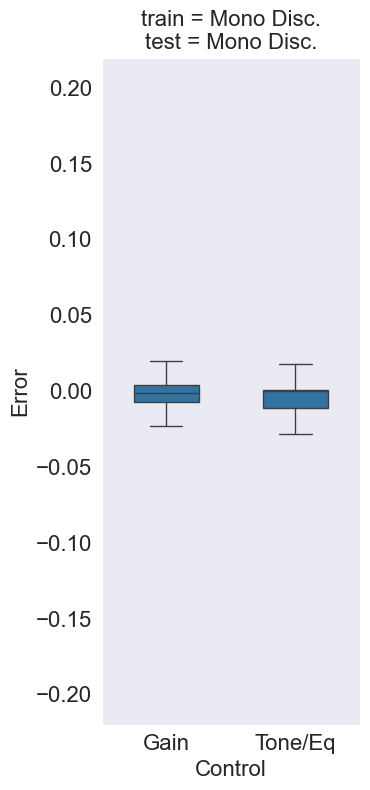

In [6]:
# BOX PLOT
err_df_mono_disc = pd.DataFrame(data={
    'Gain': test_df_mono_disc['gain_err'],
    'Tone/Eq': test_df_mono_disc['tone_eq1_err'],
})

plt.figure(figsize=(3.8,8))
plt.grid(False)
ax = utils.box_plot(error_dataframe=err_df_mono_disc, title='train = Mono Disc.\ntest = Mono Disc.', title_fontsize=16, text_fontsize=16)
ax.set(ylim=(-0.22,0.22))
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_bp_MD_MD.eps'), format='eps')

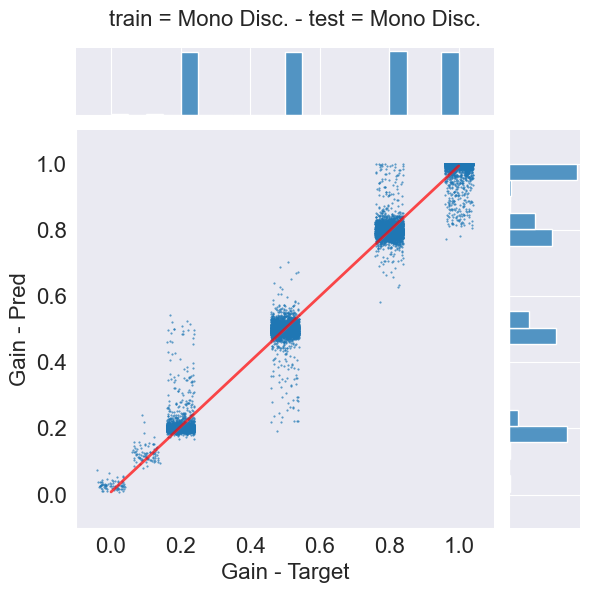

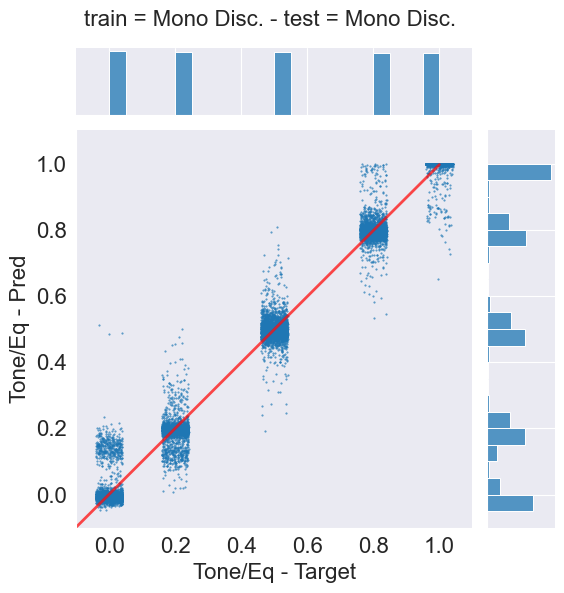

In [7]:
# SCATTER PLOT
# gain
ax = utils.scatter_plot(
    x="gain_targ", y="gain_pred", dataframe=test_df_mono_disc, 
    title='train = Mono Disc. - test = Mono Disc.', title_fontsize=16, 
    text_fontsize=16, xlabel='Gain - Target', ylabel='Gain - Pred'
)

ax.ax_marg_x.set_xlim(-0.1, 1.1)
ax.ax_marg_y.set_ylim(-0.1, 1.1)
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sp_gain_MD_MD.jpg'), dpi=500, format='jpg')

# tone/eq1
ax = utils.scatter_plot(
    x="tone_eq1_targ", y="tone_eq1_pred", dataframe=test_df_mono_disc, 
    title='train = Mono Disc. - test = Mono Disc.', title_fontsize=16, 
    text_fontsize=16, xlabel='Tone/Eq - Target', ylabel='Tone/Eq - Pred',
    bins=40
)

ax.ax_marg_x.set_xlim(-0.1, 1.1)
ax.ax_marg_y.set_ylim(-0.1, 1.1)
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sp_tone_MD_MD.jpg'), dpi=500, format='jpg')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


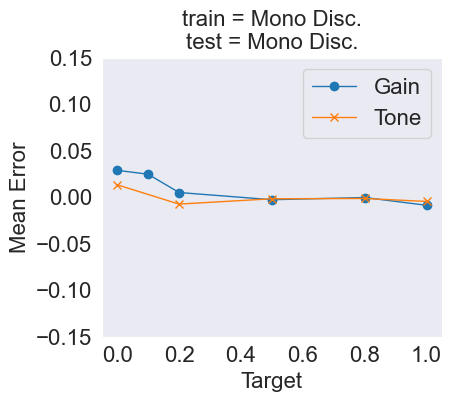

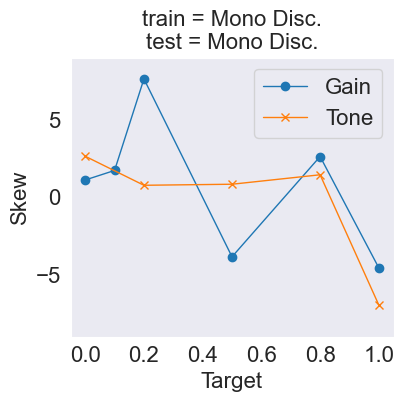

In [8]:
# MEAN ERROR and SKEW PLOTS
steps_gain = [0.0, 0.1, 0.2, 0.5, 0.8, 1.0]
steps_tone = [0.0, 0.2, 0.5, 0.8, 1.0]
avg_err_gain = []
avg_err_tone = []
skew_gain = []
skew_tone = []

for n in range(len(steps_gain)):
    df = test_df_mono_disc[test_df_mono_disc['gain_targ'] == steps_gain[n]]
    avg_err_gain.append(sum(df['gain_err']) / len(df))
    skew_gain.append(scipy.stats.skew(df['gain_err']))

for n in range(len(steps_tone)):
    df = test_df_mono_disc[test_df_mono_disc['tone_eq1_targ'] == steps_tone[n]]
    avg_err_tone.append(sum(df['tone_eq1_err']) / len(df))
    skew_tone.append(scipy.stats.skew(df['tone_eq1_err']))

# print(np.around(avg_err_gain,3))
# print(np.around(avg_err_tone,3))
# print(np.around(skew_gain,3))
# print(np.around(skew_tone,3))

# mean error
plt.figure(figsize=(4.8,4.3))
utils.line_plot(
    x_gain=steps_gain, x_tone=steps_tone, 
    y_gain=avg_err_gain, y_tone=avg_err_tone, 
    title='train = Mono Disc.\ntest = Mono Disc.' , title_fontsize=16, 
    text_fontsize=16, xlabel='Target', ylabel='Mean Error'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.15, 0.15])
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_me_MD_MD.eps'), format='eps')

# skew
plt.figure(figsize=(4.5,4.3))
ax = utils.line_plot(
    x_gain=steps_gain, x_tone=steps_tone, 
    y_gain=skew_gain, y_tone=skew_tone, 
    title='train = Mono Disc.\ntest = Mono Disc.' , title_fontsize=16, 
    text_fontsize=16, xlabel='Target', ylabel='Skew'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-9, 9])
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sk_MD_MD.eps'), format='eps')

# TEST on MONO CONTINUOUS

In [9]:
# PREPARE
# dataset
dataset_mono_cont = dataset.FxDataset(
    root='G:/PracaMagisterska/Dane/Mono_Continous_Audio',
    excl_folders=['MT2'], 
    spectra_folder='mel_22050_1024_512', 
    processed_settings_csv='proc_settings.csv',
    max_num_settings=3,
    transform=transforms.Compose([transforms.ToTensor()])
)

# initialise
dataset_mono_cont.init_dataset()
# generate features - necessary only the first time
# dataset_mono_cont.generate_mel()

# split
# set test_train_split=0.0 and val_train_split=0.0 to test pre-trained model
split_mono_cont = datasplit.DataSplit(dataset_mono_cont, test_train_split=0.0, val_train_split=0.0, shuffle=True)

# loaders
_, _, test_loader_mono_cont = split_mono_cont.get_split(batch_size=100)

len(dataset_mono_cont)

130000

In [10]:
dataset_mono_cont.mel_shape

torch.Size([128, 1, 87])

In [11]:
setnetcond.mel_shape

torch.Size([128, 1, 87])

In [12]:
# TEST
test_mono_cont_loss, test_mono_cont_correct, test_mono_cont_results = trainer.test_settings_cond_net(
    model=setnetcond, 
    test_loader=test_loader_mono_cont, 
    test_sampler=split_mono_cont.test_sampler,
    loss_function=nn.MSELoss(), 
    device='cpu'
)

# example
test_mono_cont_results[0]

====> Test Loss: 223.7404	 Avg Loss: 0.0017	Correct: 5163/130000	Percentage Correct: 3.97


(2935,
 'G71-55400-808-O4T4.1-20788',
 array([1.   , 1.   , 0.143], dtype=float32),
 array([1.  , 0.4 , 0.41], dtype=float32))

In [13]:
# Wyodrębnij poszczególne elementy z listy
test_indexes_mono_cont = [item[0] for item in test_mono_cont_results]
test_filenames_mono_cont = [item[1] for item in test_mono_cont_results]
test_preds_mono_cont = np.vstack([item[2] for item in test_mono_cont_results])
test_targets_mono_cont = np.vstack([item[3] for item in test_mono_cont_results])

# Oblicz błędy
test_abs_err_mono_cont = np.abs(test_preds_mono_cont - test_targets_mono_cont)
test_err_mono_cont = test_preds_mono_cont - test_targets_mono_cont

# Utwórz DataFrame
test_df_mono_cont = pd.DataFrame(data={
    'index': test_indexes_mono_cont, 
    'filename': test_filenames_mono_cont,
    'level_pred': test_preds_mono_cont[:, 0], 
    'gain_pred': test_preds_mono_cont[:, 1],
    'tone_eq1_pred': test_preds_mono_cont[:, 2], 
    'level_targ': test_targets_mono_cont[:, 0], 
    'gain_targ': test_targets_mono_cont[:, 1],
    'tone_eq1_targ': test_targets_mono_cont[:, 2], 
    'level_err': test_err_mono_cont[:, 0], 
    'gain_err': test_err_mono_cont[:, 1],
    'tone_eq1_err': test_err_mono_cont[:, 2], 
    'level_abs': test_abs_err_mono_cont[:, 0], 
    'gain_abs': test_abs_err_mono_cont[:, 1],
    'tone_eq1_abs': test_abs_err_mono_cont[:, 2], 
})

print(len(test_df_mono_cont))
print(test_df_mono_cont.head(3))

130000
    index                      filename  level_pred  gain_pred  tone_eq1_pred  \
0    2935    G71-55400-808-O4T4.1-20788         1.0        1.0          0.143   
1   62083  G63-63504-MGS-D9.2T3.8-20727         1.0        1.0          0.161   
2  117821  G91-54209-TS9-D2.7T1.2-21083         1.0        1.0         -0.096   

   level_targ  gain_targ  tone_eq1_targ  level_err  gain_err  tone_eq1_err  \
0         1.0       0.40           0.41        0.0      0.60        -0.267   
1         1.0       0.92           0.38        0.0      0.08        -0.219   
2         1.0       0.27           0.12        0.0      0.73        -0.216   

   level_abs  gain_abs  tone_eq1_abs  
0        0.0      0.60         0.267  
1        0.0      0.08         0.219  
2        0.0      0.73         0.216  


In [14]:
# MAE
level_mae_mono_cont = sum(test_df_mono_cont.level_abs)/len(test_df_mono_cont)
gain_mae_mono_cont = sum(test_df_mono_cont.gain_abs)/len(test_df_mono_cont)
tone_eq1_mae_mono_cont = sum(test_df_mono_cont.tone_eq1_abs)/len(test_df_mono_cont)

print('level_mae: ', level_mae_mono_cont)
print('gain_mae: ', gain_mae_mono_cont)
print('tone_eq1_mae: ', tone_eq1_mae_mono_cont)

# RMSE
level_rmse_mono_cont = math.sqrt(sum(test_df_mono_cont.level_abs**2)/len(dataset_mono_cont))
gain_rmse_mono_cont = math.sqrt(sum(test_df_mono_cont.gain_abs**2)/len(dataset_mono_cont))
tone_eq1_rmse_mono_cont = math.sqrt(sum(test_df_mono_cont.tone_eq1_abs**2)/len(dataset_mono_cont))

print('level_rmse: ', level_rmse_mono_cont)
print('gain_rmse: ', gain_rmse_mono_cont)
print('tone_eq1_rmse: ', tone_eq1_rmse_mono_cont)

level_mae:  1.4615329412313608e-06
gain_mae:  0.39471879223676826
tone_eq1_mae:  0.3862485845827623
level_rmse:  0.00015377308786271323
gain_rmse:  0.45858470745604796
tone_eq1_rmse:  0.5532022287230773


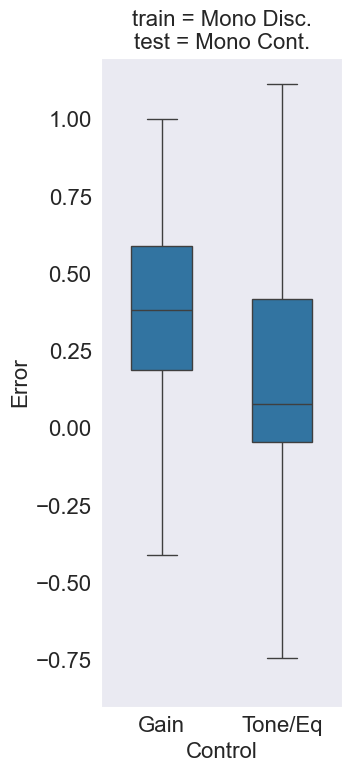

In [15]:
# BOX PLOT
err_df_mono_cont = pd.DataFrame(data={
    'Gain': test_df_mono_cont['gain_err'],
    'Tone/Eq': test_df_mono_cont['tone_eq1_err'],
})

plt.figure(figsize=(3.8,8))
ax = utils.box_plot(error_dataframe=err_df_mono_cont, title='train = Mono Disc.\ntest = Mono Cont.', title_fontsize=16, text_fontsize=16)
ax.set(ylim=(-0.90,1.2))
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_bp_MD_MC.eps'), format='eps')

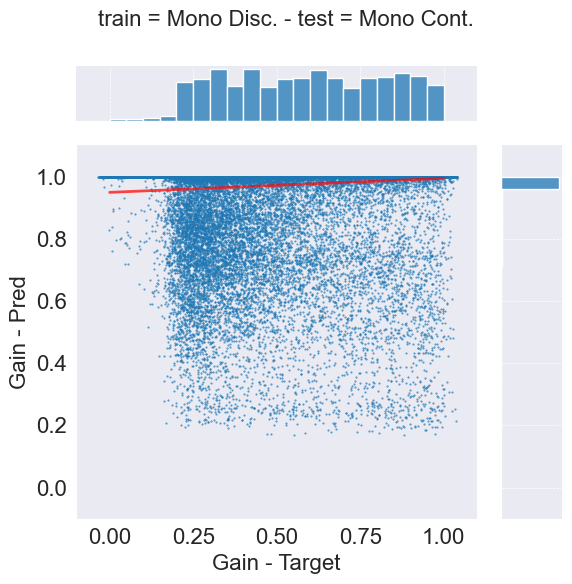

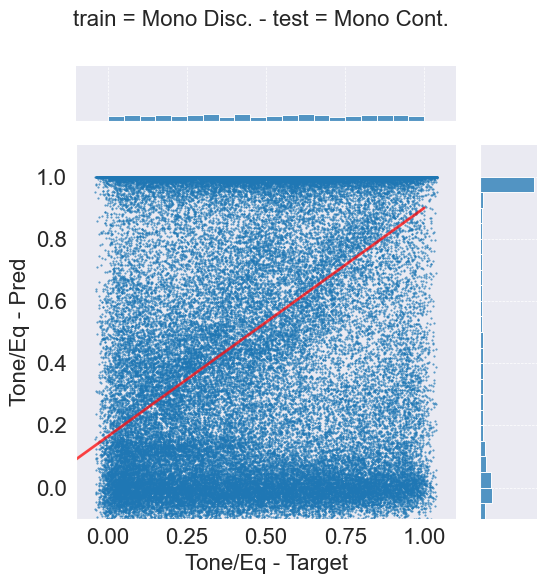

In [16]:
# SCATTER PLOT
# gain
ax = utils.scatter_plot(
    x="gain_targ", y="gain_pred", dataframe=test_df_mono_cont, 
    title='train = Mono Disc. - test = Mono Cont.', title_fontsize=16, 
    text_fontsize=16, xlabel='Gain - Target', ylabel='Gain - Pred'
)

ax.ax_marg_x.set_xlim(-0.1, 1.1)
ax.ax_marg_y.set_ylim(-0.1, 1.1)
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sp_gain_MD_MC.jpg'), dpi=500, format='png')

# tone/eq1
ax = utils.scatter_plot(
    x="tone_eq1_targ", y="tone_eq1_pred", dataframe=test_df_mono_cont, 
    title='train = Mono Disc. - test = Mono Cont.', title_fontsize=16, 
    text_fontsize=16, xlabel='Tone/Eq - Target', ylabel='Tone/Eq - Pred',
    bins=40
)

ax.ax_marg_x.set_xlim(-0.1, 1.1)
ax.ax_marg_y.set_ylim(-0.1, 1.1)
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sp_tone_MD_MC.jpg'), dpi=500, format='png')

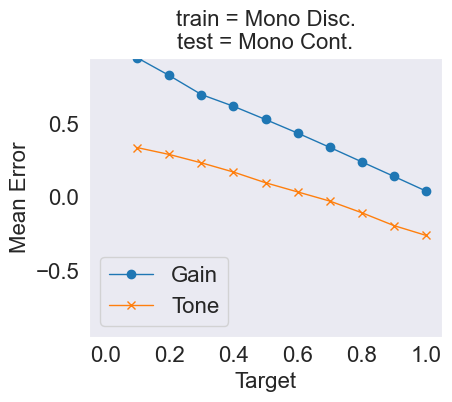

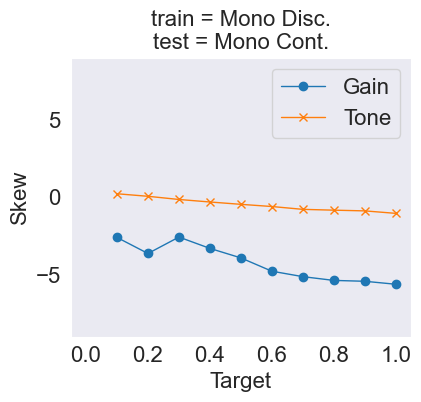

In [17]:
# MEAN ERROR and SKEW PLOTS
step_size = 0.1
steps = np.linspace(start=0, stop=1, num=int(1/step_size + 1))
avg_err_gain = []
avg_err_tone = []
skew_gain = []
skew_tone = []

for n in range(len(steps)-1):
    df = test_df_mono_cont[(test_df_mono_cont['gain_targ'] >= steps[n]) & (test_df_mono_cont['gain_targ'] < steps[n+1])]
    if len(df) > 0:
        avg_err_gain.append(sum(df['gain_err']) / len(df))
        skew_gain.append(scipy.stats.skew(df['gain_err']))
    else:
        avg_err_gain.append(np.nan)  # Możesz dodać 0 zamiast np.nan, jeśli wolisz
        skew_gain.append(np.nan)  # Możesz dodać 0 zamiast np.nan, jeśli wolisz

for n in range(len(steps)-1):
    df = test_df_mono_cont[(test_df_mono_cont['tone_eq1_targ'] >= steps[n]) & (test_df_mono_cont['tone_eq1_targ'] < steps[n+1])]
    if len(df) > 0:
        avg_err_tone.append(sum(df['tone_eq1_err']) / len(df))
        skew_tone.append(scipy.stats.skew(df['tone_eq1_err']))
    else:
        avg_err_tone.append(np.nan)  # Możesz dodać 0 zamiast np.nan, jeśli wolisz
        skew_tone.append(np.nan)  # Możesz dodać 0 zamiast np.nan, jeśli wolisz

# mean error
plt.figure(figsize=(4.8,4.3))
utils.line_plot(
    x_gain=steps[1:], x_tone=steps[1:], 
    y_gain=avg_err_gain, y_tone=avg_err_tone, 
    title='train = Mono Disc.\ntest = Mono Cont.' , title_fontsize=16, 
    text_fontsize=16, xlabel='Target', ylabel='Mean Error'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.95, 0.95])
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_me_MD_MC.eps'), format='eps')

# skew
plt.figure(figsize=(4.5,4.3))
ax = utils.line_plot(
    x_gain=steps[1:], x_tone=steps[1:],
    y_gain=skew_gain, y_tone=skew_tone, 
    title='train = Mono Disc.\ntest = Mono Cont.' , title_fontsize=16, 
    text_fontsize=16, xlabel='Target', ylabel='Skew'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-9, 9])
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sk_MD_MC.eps'), format='eps')